In [1]:
from LSTM import *
from data_getter import *
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import clear_output 
import pickle
import time

In [2]:
directory = 'D:/archive/tensors/'

In [3]:
users_tensor = load_tensor(directory+'users/')
#users_tensor = load_tensor(directory+'users/').to(device="cpu")

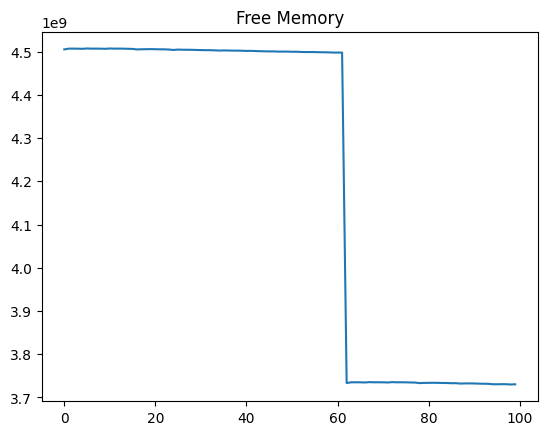

100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [04:13<00:00,  5.39s/it]


In [4]:
plot_data = {}
memory_usage = []
epochs = 3
for grade in range(6,7):
    for network in range(1,3):
        tensor =  get_tensor(directory+'data/')
        users = users_tensor[users_tensor[:,4]==grade][:,0]
        tensor = tensor[torch.isin(tensor[:,2],users)]
        tensor_data = {'users':tensor[:,2].unique(), 'problems':tensor[:,3].unique()\
              ,'networks':tensor.shape[1]-4, 'days':tensor[:,1].max()}
        model = LSTM(tensor_data,3,3,hidden_3=10)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.7)
        #training
        for epoch in range(epochs):
            model.split_users()
            model.reset_tensor()
            #mini_batches = model.training_users.shape[0]//20
            mini_batches = 5
            for mini_batch_number in tqdm(range(mini_batches)):
                mini_batch_users = model.get_mini_batch('train')
                mini_batch = tensor[torch.isin(tensor[:,2],mini_batch_users)]
                for n in range(1,model.days):
                    data = mini_batch[mini_batch[:,1]==n]
                    if data.shape[0]>0:
                        ground = data[:,-1].to(dtype=torch.float)
                        if network == 1:
                            output = model(data)
                        else:
                            output = model.forward_topics(data)
                        loss = model.loss(ground,output)
                        loss.backward()
                        optimizer.step()
                        optimizer.zero_grad()
                        model.h.detach_()
                        model.C.detach_()
                    
                clear_output()    
                r = torch.cuda.memory_reserved(0)
                a = torch.cuda.memory_allocated(0)
                memory_usage.append(r-a)
                if len(memory_usage)>100:
                    memory_useage = memory_usage[:100]
                plt.title('Free Memory')
                plt.plot(memory_usage)
                plt.show()
            
        #test
        x = []
        y = []
        batch_number = 0
        for mini_batch_number in tqdm(range(model.test_users.shape[0]//20)):
            mini_batch_users = model.get_mini_batch('test')
            mini_batch = tensor[torch.isin(tensor[:,2],mini_batch_users)]
            batch_number += 1
            losses = []
            prediction_count = 0
            ground_count = 0
            problem_count = 0
            for n in range(1,model.days):
                data = mini_batch[mini_batch[:,1]==n]
                if data.shape[0]>0:
                    if network == 1:
                        output = model(data)
                    else:
                        output = model.forward_topics(data)
                    ground = data[:,-1].to(dtype=torch.float)
                    loss = model.loss(ground,output)
                    loss.backward()
                    optimizer.step()
                    optimizer.zero_grad()
                    losses.append(loss.item())
                    model.h.detach_()
                    model.C.detach_()
                    
            clear_output()
            r = torch.cuda.memory_reserved(0)
            a = torch.cuda.memory_allocated(0)
            memory_usage.append(r-a)
            if len(memory_usage)>100:
                memory_usage = memory_usage[:100]
            plt.title('Free Memory')
            plt.plot(memory_usage)
            plt.show()
            
            x.append(batch_number)
            y.append(sum(losses)/len(losses))
        plot_data[(grade,network)] = (x,y)
        del tensor
        del model
name = 'topics_all_grades_network_'+str(int(time.time()))
file = open('data/' + name + '.pkl', 'wb+')
pickle.dump(plot_data,file)
file.close()

In [5]:
print('File Name: ', name)

File Name:  topics_all_grades_network_1699777388


In [6]:
file = open('data/gender_all_grades_network_1696851271.pkl','rb') 
plot_data = pickle.load(file)

C:\Users\bentr\AppData\Local\Temp\ipykernel_21864\26680446.py:34: RuntimeWarning: divide by zero encountered in divide
  y = list(np.mean(one_network,axis=0)*12/(sum(one_network[:,0]==0)))
C:\Users\bentr\AppData\Local\Temp\ipykernel_21864\26680446.py:38: RuntimeWarning: divide by zero encountered in divide
  y = list(np.mean(two_networks,axis=0)*12/(sum(one_network[:,0]==0)))


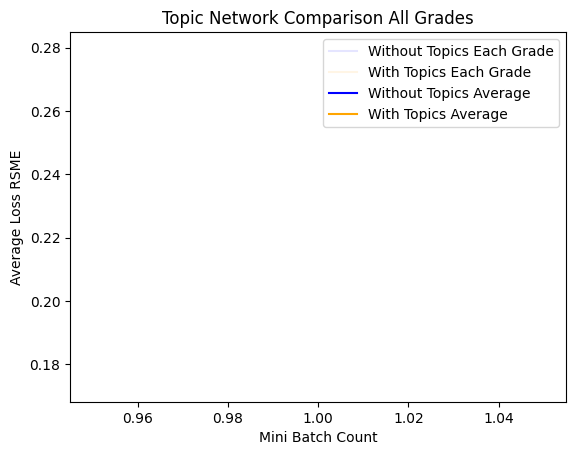

In [7]:
min_points = np.inf
for key in list(plot_data.keys()):
    if len(plot_data[key][0])<0:
        plot_data.pop(key)
    else: 
        min_points = min([min_points,len(plot_data[key][0])])
one_network = np.zeros((12,min_points))
two_networks = np.zeros((12,min_points))
for key in plot_data.keys():
    if key[1] == 1:
        one_network[key[0]-1,:] = np.array(plot_data[key][1][:min_points])
    else:
        two_networks[key[0]-1,:] = np.array(plot_data[key][1][:min_points])
plotted_one = False
plotted_two = False
for key in plot_data.keys():
    x, y = plot_data[key]
    x = x[:min_points]
    y = y[:min_points]
    y_padded = 10*[y[0]]+y
    running_sum = [sum(y_padded[n:n+10])/10 for n in range(len(y))]
    if key[1] == 1:
        if plotted_one: 
            plt.plot(x,running_sum,alpha=0.1,color="blue")
        else: 
            plt.plot(x,running_sum,alpha=0.1,color="blue", label="Without Topics Each Grade")
            plotted_one = True
    else: 
        if plotted_two: 
            plt.plot(x,running_sum,alpha=0.1,color="orange")
        else: 
            plt.plot(x,running_sum,alpha=0.1,color="orange", label= "With Topics Each Grade")
            plotted_two = True
y = list(np.mean(one_network,axis=0)*12/(sum(one_network[:,0]==0)))
y_padded = 10*[y[0]]+y
running_sum = [sum(y_padded[n:n+10])/10 for n in range(len(y))]
plt.plot(x,running_sum,color="blue",label="Without Topics Average")
y = list(np.mean(two_networks,axis=0)*12/(sum(one_network[:,0]==0)))
y_padded = 10*[y[0]]+y
running_sum = [sum(y_padded[n:n+10])/10 for n in range(len(y))]
plt.plot(x,running_sum,color="orange",label="With Topics Average")
plt.title("Topic Network Comparison All Grades")
plt.xlabel("Mini Batch Count")
plt.ylabel("Average Loss RSME")
plt.legend()
plt.show()